In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from matplotlib import pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [9]:
dataset = torchvision.datasets.ImageFolder(root='..\\instrument_dataset', transform=transform)

In [10]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [19]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=len(dataset.classes)):
        super(CNNModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(8)

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(32)

        self.conv4 = nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(128)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)

        self.fc = nn.Linear(12800, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = f.relu(x)
        x = self.maxpool(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = f.relu(x)
        x = self.maxpool(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = f.relu(x)
        x = self.maxpool(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = f.relu(x)
        x = self.maxpool(x)

        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)

        return x

In [ ]:
model = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_arr = []

epochs = 40
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")
    loss_arr.append(running_loss/len(train_loader))

Epoch 1/40, Loss: 0.9924235927523114
Epoch 2/40, Loss: 0.008142279778743008
Epoch 3/40, Loss: 0.0028223753169489404
Epoch 4/40, Loss: 0.0011799663411996637
Epoch 5/40, Loss: 0.0006983546823903453
Epoch 6/40, Loss: 0.0005941451322238815
Epoch 7/40, Loss: 0.003082251313389861
Epoch 8/40, Loss: 0.0005881244901199049
Epoch 9/40, Loss: 0.00021817543668779156
Epoch 10/40, Loss: 0.00030263153166742995
Epoch 11/40, Loss: 0.00019732837008632487
Epoch 12/40, Loss: 9.083487263220984e-05
Epoch 13/40, Loss: 0.00012535413170553512
Epoch 14/40, Loss: 9.254705907248232e-05
Epoch 15/40, Loss: 0.00010285295620633405
Epoch 16/40, Loss: 9.161188772850437e-05
Epoch 17/40, Loss: 6.800440623919713e-05
Epoch 18/40, Loss: 7.21456316568947e-05
Epoch 19/40, Loss: 5.7753114348694604e-05
Epoch 20/40, Loss: 8.761231692915317e-05
Epoch 21/40, Loss: 5.5944866441374565e-05
Epoch 22/40, Loss: 5.287133620489233e-05
Epoch 23/40, Loss: 4.382125175652618e-05


KeyboardInterrupt: 

In [21]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Validation Accuracy: {correct / total:.2f}')


Validation Accuracy: 1.00


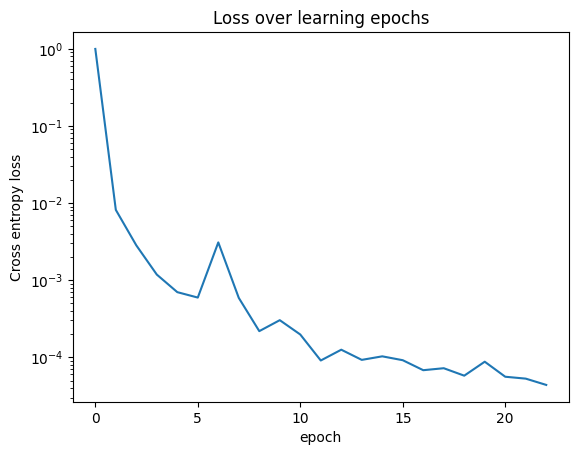

In [25]:
plt.figure()
plt.semilogy(loss_arr)
plt.xlabel("epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss over learning epochs")
plt.show()